<a href="https://colab.research.google.com/github/danielarruda1000/machine_learn_previsao_letalidade_rj/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TCC**

**Título do Trabalho**:
Modelo de previsão de taxa de letalidade violenta no estado do Rio de
Janeiro

**Resumo**: O trabalho visa aplicar 6 modelos estatísticos e comparar o desempenho de cada um para prever a taxa de letalidade violenta no estado do Rio de Janeiro por 100 mil habitantes. Os modelos aplicados para esse trabalho são: 
* ARIMA(1,1,0)
* ARIMA(1,1,1)
* ARIMA(1,1,2)
* ARIMA(2,1,0)
* ARIMA(2,1,1)
* ARIMA(2,1,2)

Nome: Daniel Nascimento Arruda |
Email: danielarruda1000@gmail.com | 
Whatsapp: 21984088497

## Importando bibliotecas necessárias

In [31]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import (plot_acf, plot_pacf)

from scipy.stats import shapiro, normaltest
from scipy.stats import boxcox
from scipy.special import inv_boxcox


sns.set(rc={'figure.figsize':(10,5)})

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/TCC

## Lendo os dados e processando a série histórica

In [8]:
df = pd.read_csv('BaseEstadoTaxaMes.csv', sep=';')
df = df[['ano','mes','mes_ano','letalidade_violenta']].rename(columns={'ano':'year','mes':"month"})
df['data'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df['letalidade_violenta'] = df['letalidade_violenta'].str.replace(',','.').astype(float)
df = df[(df['data'] >= pd.to_datetime('2005-01-01')) & (df['data'] < pd.to_datetime('2022-01-01'))] # Dados a partir de 2005
df = df[['letalidade_violenta', 'data']].reset_index(drop=True)

In [9]:
df

,letalidade_violenta,data
0,4.67,2005-01-01
1,4.60,2005-02-01
2,5.32,2005-03-01
3,4.04,2005-04-01
4,4.49,2005-05-01
...,...,...
199,2.21,2021-08-01
200,2.05,2021-09-01
201,2.32,2021-10-01
202,1.86,2021-11-01


## Analisando os dados

### Gráfico da série temporal

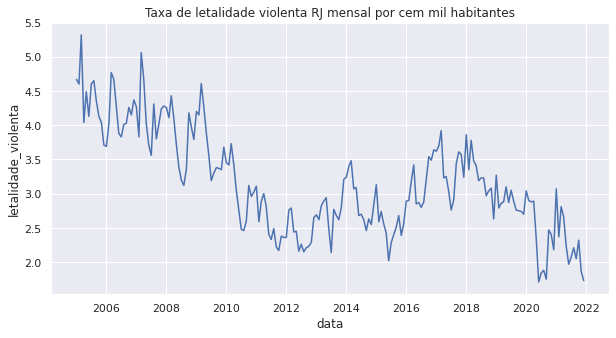

In [10]:
sns.lineplot(data=df, x='data', y='letalidade_violenta')
plt.title('Taxa de letalidade violenta RJ mensal por cem mil habitantes')
plt.show()

### Estatísticas gerais

In [15]:
df['letalidade_violenta'].describe()

Estatísticas gerais:


count    204.000000
mean       3.158333
std        0.747854
min        1.710000
25%        2.620000
50%        3.045000
75%        3.702500
max        5.320000
Name: letalidade_violenta, dtype: float64

### Gráfico da FAC e FACP

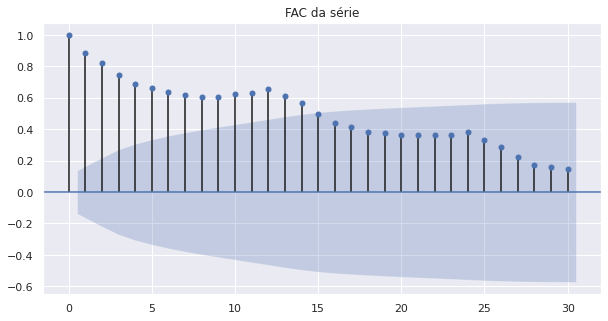

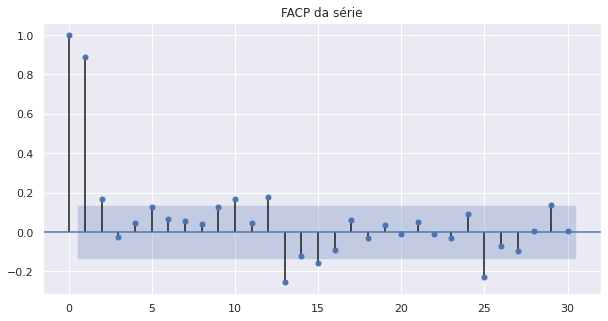

In [17]:
plot_acf(df['letalidade_violenta'],lags=30)
plt.title('FAC da série')
plt.show()

plot_pacf(df['letalidade_violenta'],lags=30)
plt.title('FACP da série')
plt.show()

### Gráfico da decomposiçao aditiva da série temporal

				Decomposição da série temporal


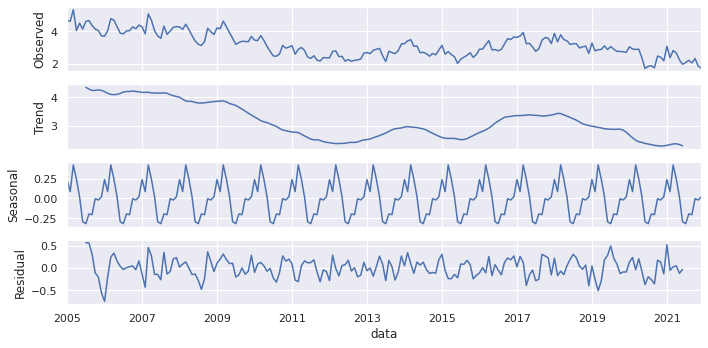

In [16]:
print('\t\t\t\tDecomposição da série temporal')
seasonal_decompose(df.set_index('data')['letalidade_violenta'], model='additive').plot()
plt.show()

### Teste de normalidade

In [35]:
def normaltest_funcs(serie, alpha=0.05):

  print('Shapiro-Wilk teste:\n')
  stat, p = shapiro(serie)

  print('Statistics=%.3f, p=%.3f' % (stat, p))
  if p > alpha:
    print('Os dados estão normalmente distribuidos (Falha em rejeitar a hipótese nula (H0))')
  else:
    print('Os dados não estão normalmente distribuidos (Rejeita H0) ')

  print("\nD'Agostino's K2:\n")

  stat, p = normaltest(serie)

  print('Statistics=%.3f, p=%.3f' % (stat, p))
  if p > alpha:
    print('Os dados estão normalmente distribuidos (Falha em rejeitar a hipótese nula (H0))')
  else:
    print('Os dados não estão normalmente distribuidos (Rejeita H0) ')

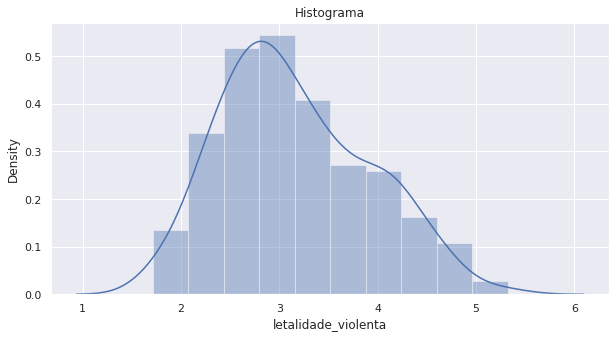

Shapiro-Wilk teste:

Statistics=0.976, p=0.001
Os dados não estão normalmente distribuidos (Rejeita H0) 

D'Agostino's K2:

Statistics=8.639, p=0.013
Os dados não estão normalmente distribuidos (Rejeita H0) 


In [37]:
sns.distplot(df['letalidade_violenta'])
plt.title('Histograma')
plt.show()

normaltest_funcs(df['letalidade_violenta'])

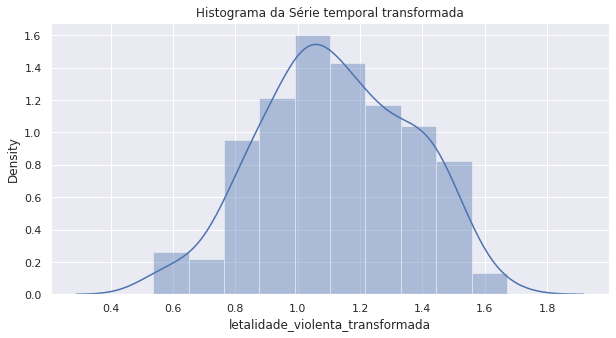

Shapiro-Wilk teste:

Statistics=0.990, p=0.146
Os dados estão normalmente distribuidos (Falha em rejeitar a hipótese nula (H0))

D'Agostino's K2:

Statistics=4.152, p=0.125
Os dados estão normalmente distribuidos (Falha em rejeitar a hipótese nula (H0))


In [38]:
# Transformação da série para normalizar utilizando o método Box-Cox

df['letalidade_violenta_transformada'] = boxcox(df['letalidade_violenta'], 0)

sns.distplot(df['letalidade_violenta_transformada'])
plt.title('Histograma da Série temporal transformada')
plt.show()

normaltest_funcs(df['letalidade_violenta_transformada'])

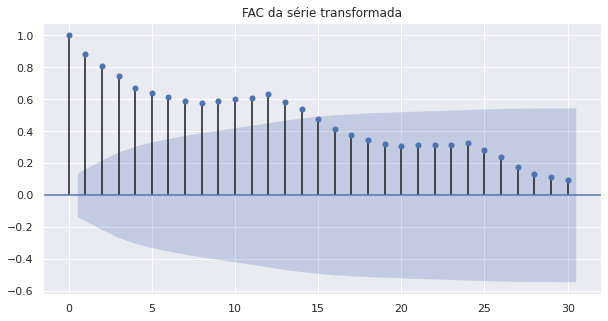

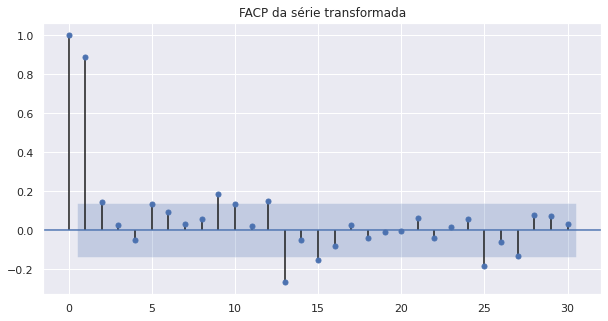

In [43]:
plot_acf(df['letalidade_violenta_transformada'],lags=30)
plt.title('FAC da série transformada')
plt.show()

plot_pacf(df['letalidade_violenta_transformada'],lags=30)
plt.title('FACP da série transformada')
plt.show()

## Metodologia Box-Jenkins

### Aplicando diferenciação
* Usando diferenciação simples = 1 para tranformar a série temporal em estacionária com 95% de signicancia

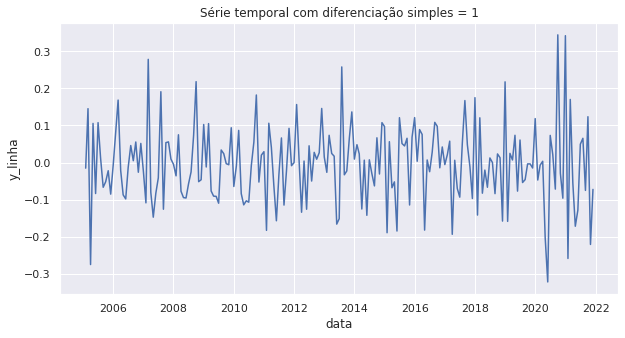

ADF Statistic: -4.711381196005209
p-value: 8.010618676682394e-05
Critical Values:
	1%: -3.465058702600837
	5%: -2.8767942675230356
	10%: -2.5749014492475535


In [47]:
# Gerando a série estacionaria com a tecnica de diferenciação (Y' em t = Y em t - Y em t-1)

df['y_linha'] = df['letalidade_violenta_transformada'].diff()

sns.lineplot(data=df, x='data', y='y_linha')
plt.title('Série temporal com diferenciação simples = 1')
#plt.axhline(df['y_linha'].mean(), color='red')
plt.show()

# Teste para ver se a série é estacionária
result = adfuller(df['y_linha'].dropna())
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

* P-Valor menor que 5% e a estatística obtida é menor que o valor crítido, desse modo não se rejeita a hipótese nula (a série temporal é estacionária). A diferenciação simples = 1 será o parâmetro d em todos os modelos ARIMA que serão ajustados

### Modelos ARIMA
* Serão usados dados de janeiro de 2005 até 2020 para ajustar e analisar a performance de cada um. E por fim eleger o melhor.
* Para a previsão serão usados os dados de janeiro de 2021 até dezembro de 2021

In [52]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import (mean_absolute_percentage_error, mean_squared_error, r2_score)

def run_arima_model(p,d,q, serie):

  print(f'RODANDO ARIMA({p},{d},{q})')

  # Separando dados de treino e teste
  train = serie.dropna()[:192] # 2005 até 2020
  #test = serie.dropna()[192:] # 2021

  # Ajustando o modelo
  arima_model = ARIMA(train, order=(p,d,q))
  model = arima_model.fit()
  print(model.summary())
  model.plot_predict(dynamic=False)
  plt.show()

  print('\n\nPERFORMANCE:')

  performance_df = pd.concat([model.predict(), train], axis=1)
  performance_df['pred'] = performance_df[0] + performance_df['letalidade_violenta_transformada'].shift(1)
  performance_df['residuo'] = performance_df['letalidade_violenta_transformada'] - performance_df['pred']
  performance_df = performance_df.dropna()

  mape = mean_absolute_percentage_error(performance_df['letalidade_violenta_transformada'], performance_df['pred'])
  rmse = mean_squared_error(performance_df['letalidade_violenta_transformada'], performance_df['pred'])
  r2 = r2_score(performance_df['letalidade_violenta_transformada'], performance_df['pred'])

  print(f'MAPE: {round(mape*100,2)}%')
  print(f'RMSE: {round(rmse,2)}')
  print(f'R2: {round(r2,2)}')

  plot_acf(performance_df['residuo'].dropna(),lags=24)
  plt.title(f'FAC dos resíduos ARIMA({p},{d},{q})')
  plt.show()

  df_metrics = pd.DataFrame({'Modelo': [f'ARIMA({p},{d},{q})'], 'R2': [r2], 'MAPE': [mape], 'RMSE': [rmse]}, columns=['Modelo', 'R2', 'MAPE', 'RMSE'])
  return df_metrics
  
  """
  # Output do modelo para 2021
  fc, se, conf = model.forecast(12, alpha=0.05)

  fc_series = pd.Series(fc, index = test.index)
  
  lower_series = pd.Series(conf[:, 0], index = test.index)
  upper_series = pd.Series(conf[:, 1], index = test.index)

  # Plot
  sns.lineplot(data=train, label='Série temporal transformada')
  sns.lineplot(data=fc_series, label='Previsão')
  plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
  plt.title('Previsão 2021')
  plt.show()

  meses = pd.DataFrame({'mes': ['jan', 'fev', 'mar', 'abri', 'mai', 'jun', 'jul', 'ago', 'set', 'nov', 'dez']}, columns=['mes'])
  meses['previsao'] = inv_boxcox(fc_series.reset_index(drop=True), 0)
  
  print('\n',meses)
  """

  

#### ARIMA (1,1,0)

RODANDO ARIMA(1,1,0)
                                     ARIMA Model Results                                      
Dep. Variable:     D.letalidade_violenta_transformada   No. Observations:                  191
Model:                                 ARIMA(1, 1, 0)   Log Likelihood                 173.793
Method:                                       css-mle   S.D. of innovations              0.097
Date:                                Thu, 26 May 2022   AIC                           -341.586
Time:                                        17:18:15   BIC                           -331.829
Sample:                                             1   HQIC                          -337.634
                                                                                              
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
c

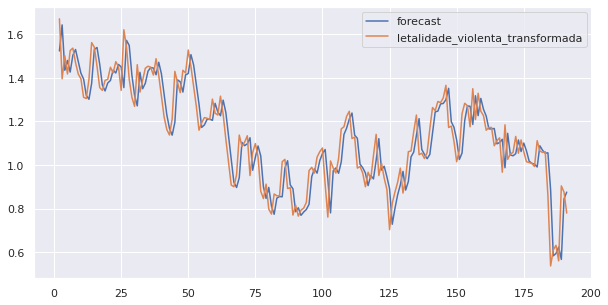



PERFORMANCE:
MAPE: 6.97%
RMSE: 0.01
R2: 0.81


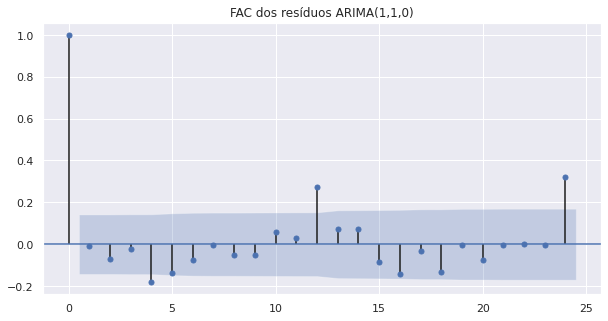

In [59]:
model_1_metric = run_arima_model(1,1,0, df['letalidade_violenta_transformada'])

#### ARIMA (1,1,1)

RODANDO ARIMA(1,1,1)
                                     ARIMA Model Results                                      
Dep. Variable:     D.letalidade_violenta_transformada   No. Observations:                  191
Model:                                 ARIMA(1, 1, 1)   Log Likelihood                 179.062
Method:                                       css-mle   S.D. of innovations              0.095
Date:                                Thu, 26 May 2022   AIC                           -350.123
Time:                                        17:18:16   BIC                           -337.114
Sample:                                             1   HQIC                          -344.854
                                                                                              
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
c

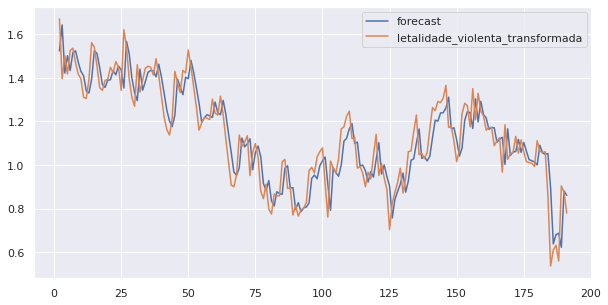



PERFORMANCE:
MAPE: 6.9%
RMSE: 0.01
R2: 0.82


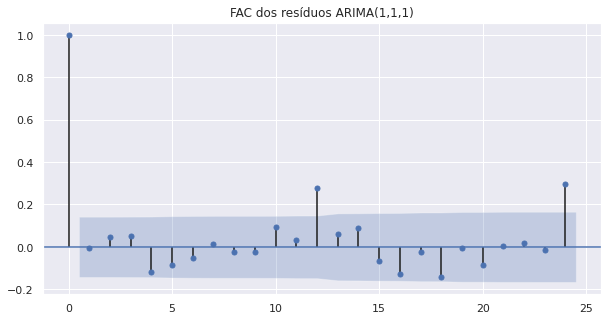

In [60]:
model_2_metric = run_arima_model(1,1,1, df['letalidade_violenta_transformada'])

#### ARIMA (1,1,2)

RODANDO ARIMA(1,1,2)
                                     ARIMA Model Results                                      
Dep. Variable:     D.letalidade_violenta_transformada   No. Observations:                  191
Model:                                 ARIMA(1, 1, 2)   Log Likelihood                 179.068
Method:                                       css-mle   S.D. of innovations              0.095
Date:                                Thu, 26 May 2022   AIC                           -348.136
Time:                                        17:18:17   BIC                           -331.874
Sample:                                             1   HQIC                          -341.549
                                                                                              
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
c

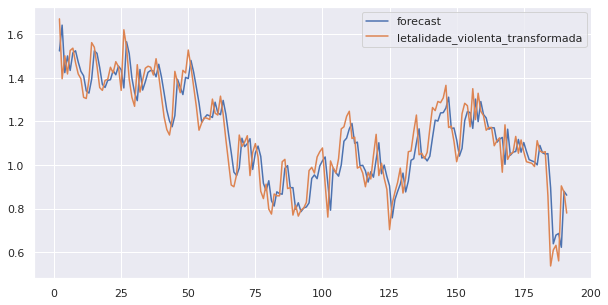



PERFORMANCE:
MAPE: 6.89%
RMSE: 0.01
R2: 0.82


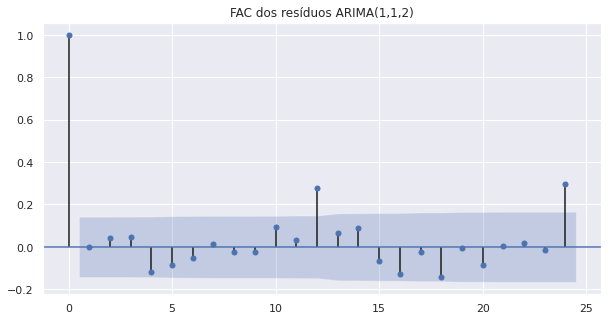

In [61]:
model_3_metric = run_arima_model(1,1,2, df['letalidade_violenta_transformada'])

#### ARIMA (2,1,0)

RODANDO ARIMA(2,1,0)
                                     ARIMA Model Results                                      
Dep. Variable:     D.letalidade_violenta_transformada   No. Observations:                  191
Model:                                 ARIMA(2, 1, 0)   Log Likelihood                 174.239
Method:                                       css-mle   S.D. of innovations              0.097
Date:                                Thu, 26 May 2022   AIC                           -340.477
Time:                                        17:18:18   BIC                           -327.468
Sample:                                             1   HQIC                          -335.208
                                                                                              
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
c

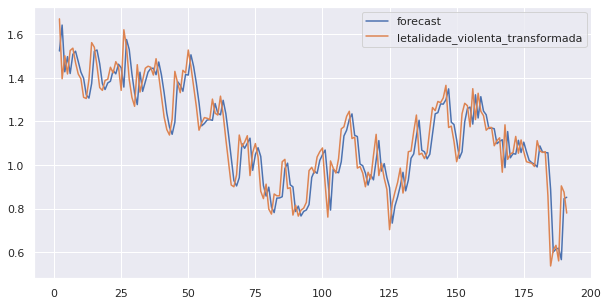



PERFORMANCE:
MAPE: 6.94%
RMSE: 0.01
R2: 0.81


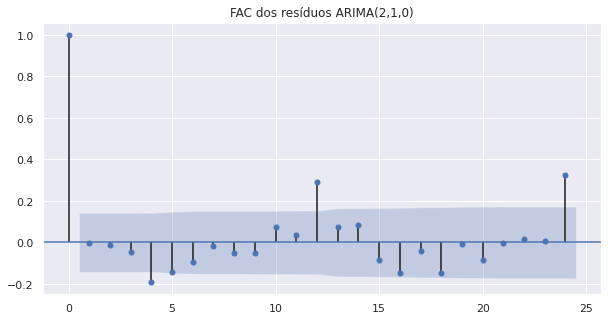

In [62]:
model_4_metric = run_arima_model(2,1,0, df['letalidade_violenta_transformada'])

#### ARIMA (2,1,1)

RODANDO ARIMA(2,1,1)
                                     ARIMA Model Results                                      
Dep. Variable:     D.letalidade_violenta_transformada   No. Observations:                  191
Model:                                 ARIMA(2, 1, 1)   Log Likelihood                 174.441
Method:                                       css-mle   S.D. of innovations              0.097
Date:                                Thu, 26 May 2022   AIC                           -338.882
Time:                                        17:18:19   BIC                           -322.621
Sample:                                             1   HQIC                          -332.295
                                                                                              
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
c

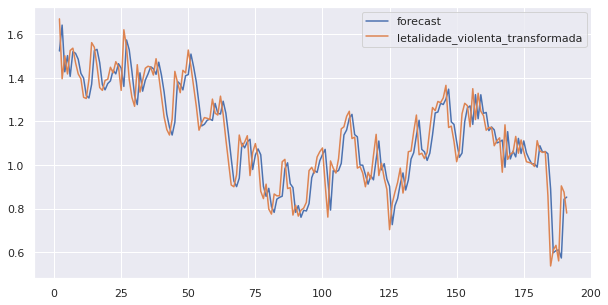



PERFORMANCE:
MAPE: 6.94%
RMSE: 0.01
R2: 0.81


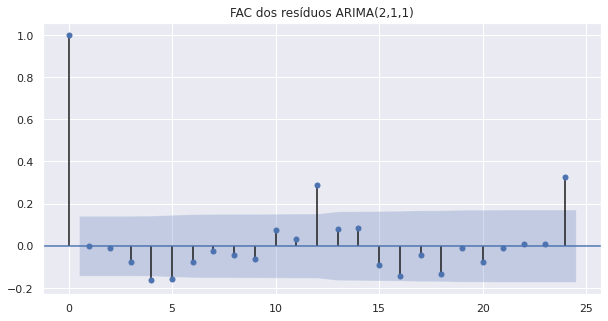

In [63]:
model_5_metric = run_arima_model(2,1,1, df['letalidade_violenta_transformada'])

#### ARIMA (2,1,2)

RODANDO ARIMA(2,1,2)
                                     ARIMA Model Results                                      
Dep. Variable:     D.letalidade_violenta_transformada   No. Observations:                  191
Model:                                 ARIMA(2, 1, 2)   Log Likelihood                 179.599
Method:                                       css-mle   S.D. of innovations              0.094
Date:                                Thu, 26 May 2022   AIC                           -347.197
Time:                                        17:18:20   BIC                           -327.683
Sample:                                             1   HQIC                          -339.293
                                                                                              
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
c

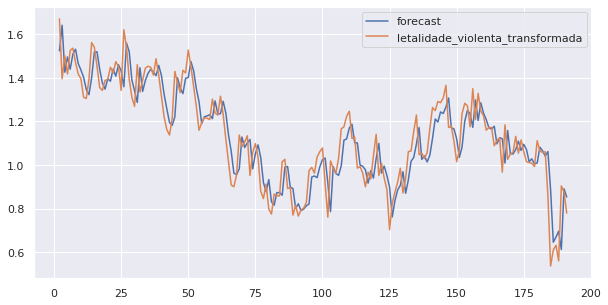



PERFORMANCE:
MAPE: 6.89%
RMSE: 0.01
R2: 0.82


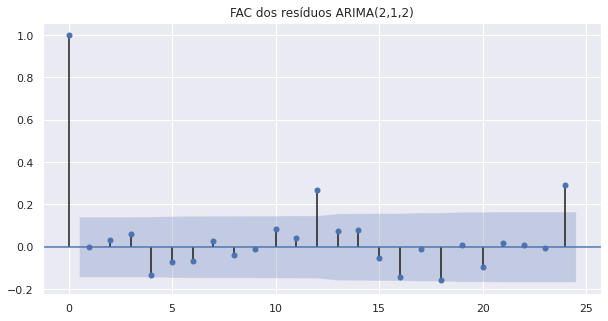

In [64]:
model_6_metric = run_arima_model(2,1,2, df['letalidade_violenta_transformada'])

### Resultados

In [65]:
df_metric = pd.concat([
                       model_1_metric,
                       model_2_metric,
                       model_3_metric,
                       model_4_metric,
                       model_5_metric,
                       model_6_metric
])

df_metric = df_metric.sort_values(['R2', 'MAPE','RMSE'], ascending=False).reset_index(drop=True)
df_metric['MAPE'] *= 100

In [66]:
df_metric

,Modelo,R2,MAPE,RMSE
0,"ARIMA(2,1,2)",0.822273,6.885669,0.008982
1,"ARIMA(1,1,2)",0.821259,6.894137,0.009033
2,"ARIMA(1,1,1)",0.821237,6.900807,0.009034
3,"ARIMA(2,1,1)",0.812567,6.937243,0.009473
4,"ARIMA(2,1,0)",0.812183,6.941987,0.009492
5,"ARIMA(1,1,0)",0.811305,6.968851,0.009536


* O melhor modelo dentre os que foram usados é o ARIMA(2,1,2) pois apresentou maior R2, menor MAPE e menor RMSE

#### Realizando previsão

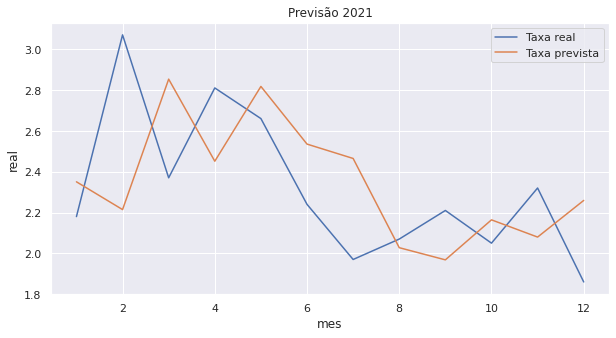

MAPE: 13.62%
RMSE: 0.15
R2: -0.24


In [114]:
previsoes = []
real = []

for train_range in range(191, 203):

  train = df['letalidade_violenta_transformada'][:train_range]
  test = df['letalidade_violenta_transformada'][train_range:].head(1)

  arima_model = ARIMA(train, order=(2,1,2))
  model = arima_model.fit()

  fc, se, conf = model.forecast(1, alpha=0.05)
  fc_series = pd.Series(fc, index = test.index)

  previsoes.append(fc_series.values[0])
  real.append(test.values[0])

# Dataset com as previsoes e valores reais
validacao = pd.DataFrame({'previsao': previsoes, 'real': real}, columns=['previsao','real'])
validacao = validacao.reset_index().rename(columns={'index':'mes'})
validacao['mes']+=1

# Pegando os valores na escala original
validacao['real'] = inv_boxcox(validacao['real'] , 0)
validacao['previsao'] = inv_boxcox(validacao['previsao'] , 0)

sns.lineplot(data=validacao, x='mes', y='real', label='Taxa real')
sns.lineplot(data=validacao, x='mes', y='previsao', label='Taxa prevista')
plt.title('Previsão 2021')
plt.show()

mape = mean_absolute_percentage_error(validacao['real'], validacao['previsao'])
rmse = mean_squared_error(validacao['real'], validacao['previsao'])
r2 = r2_score(validacao['real'], validacao['previsao'])

print(f'MAPE: {round(mape*100,2)}%')
print(f'RMSE: {round(rmse,2)}')
print(f'R2: {round(r2,2)}')

In [116]:
validacao[['mes', 'previsao']]

,mes,previsao
0,1,2.350410
1,2,2.214364
2,3,2.853088
3,4,2.451145
4,5,2.817448
5,6,2.535075
6,7,2.464689
7,8,2.027774
8,9,1.968189
9,10,2.164080


In [119]:
validacao[['previsao', 'real']].describe()

,previsao,real
count,12.000000,12.000000
mean,2.348764,2.317500
std,0.288112,0.360331
min,1.968189,1.860000
25%,2.142989,2.065000
50%,2.304801,2.225000
75%,2.482286,2.442500
max,2.853088,3.070000
